In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [171]:
# df = pd.read_csv('weekly_dmd.csv')
df = pd.read_csv('weekly_dmd_new.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,year,total_demand_new_lag4,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor
date_idx,,,,,,,,,,,,,,,,,,
2017-06-26,1,2017-06-26,1900.845050,NaN,NaN,NaN,2155.673157,2193.532475,2110.494687,NaN,2017,NaN,NaN,6,26,26,NaN,NaN
2017-06-26,143,2017-06-26,30.600278,NaN,NaN,NaN,38.901262,40.511522,40.070036,NaN,2017,NaN,NaN,6,26,26,NaN,NaN


In [172]:
df.date.max()

datetime.date(2021, 8, 2)

In [180]:
def set_lag_features(df, col, lags):
    """lags: array of desired lags to compute"""
    
    df.sort_values('date', ascending=True, inplace=True)
    
    for lag in lags:
        df[f'{col}_lag{lag}'] = df.groupby('zone_id')[col].shift(lag)
        
    return df

In [181]:
response = 'total_demand'
df = set_lag_features(df, f'{response}_new', [5,6,7])

<ipython-input-1205-29803c084a1b>:7: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwint

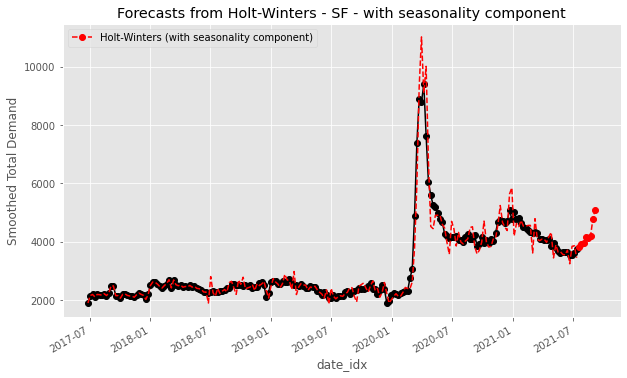

In [1205]:
### Out of the box holt-winters model to compare with below "modified" holt-winters implementation that handles covid

zdf = df1.sort_values('date').total_demand_new.astype(float)

fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
                            seasonal_periods=52,
                            damped=False
                           ).fit(optimized=True, use_boxcox=False)

ax = zdf.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters - SF - with seasonality component" )
ax.set_ylabel("Smoothed Total Demand")
ax.set_xlabel("Week")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')

fit1.forecast(8).rename('Holt-Winters (with seasonality component)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

In [1206]:
fit1.params

{'smoothing_level': 0.8889285714285714,
 'smoothing_trend': 0.8230820105820106,
 'smoothing_seasonal': 0.1110714285714286,
 'damping_trend': nan,
 'initial_level': 2783.5069797410138,
 'initial_trend': 2.386143219742208,
 'initial_seasons': array([0.68289574, 0.77444503, 0.78804634, 0.75821426, 0.7884416 ,
        0.78535444, 0.7800498 , 0.79779579, 0.77496207, 0.8049305 ,
        0.89501213, 0.8930455 , 0.7739801 , 0.7729854 , 0.74207211,
        0.78991075, 0.79566146, 0.77662844, 0.76978372, 0.76735162,
        0.75392567, 0.78446413, 0.80469954, 0.78912728, 0.77667462,
        0.72745409, 0.78769021, 0.90074226, 0.94180849, 0.93834758,
        0.91596839, 0.88651684, 0.86766494, 0.89792067, 0.92251673,
        0.97017268, 0.86870371, 0.9664977 , 0.90869349, 0.89537723,
        0.90601365, 0.87712368, 0.88626101, 0.88056957, 0.89936271,
        0.87801349, 0.88820917, 0.86324305, 0.8591175 , 0.84884055,
        0.8179303 , 0.81807011]),
 'use_boxcox': False,
 'lamda': None,
 'remove

<AxesSubplot:>

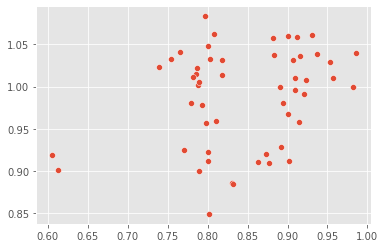

In [165]:
sns.scatterplot(x=fit1.params['initial_seasons'], y=map_estimate['initial_szns'])

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/results.py:169: FutureWarning: slope is deprecated and will be removed after 0.13
  warnings.warn(


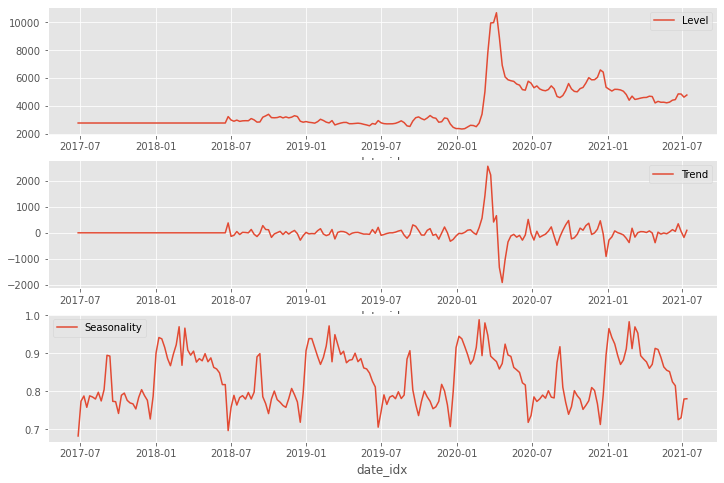

In [1207]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season, fit1.fittedvalues], columns=['level','slope','seasonal', 'fitted_val'], index=zdf.index)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,8))
states1.level.plot(ax=ax1, label='Level')
states1.slope.plot(ax=ax2, label='Trend')
states1.seasonal.plot(ax=ax3, label='Seasonality')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

##### Start adding dampener

In [122]:
# [X] dampening
# [] fit on horizon-steps ahead

def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if False: # force using seasonal estimates
#         if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    
        trend_dampener = pm.Uniform('trend_dampener', lower=0, upper=1)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + trend_dampener*prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + trend_dampener*prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*trend_dampener*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [123]:
# [] dampening
# [] fit on horizon-steps ahead

def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + map_estimate['trend_dampener']*prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + map_estimate['trend_dampener']*prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*map_estimate['trend_dampener']*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
#     pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
    trend_multiplier = np.sum([map_estimate['trend_dampener']**i for i in range(1,horizon+1)])
    pred = (levels.get_test_value()[-1] + trend_multiplier*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [480]:
# [X] dampening
# [...] fit on horizon-steps ahead
n_steps_ahead = 5

def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
#         smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
        smoothing_level = pm.TruncatedNormal('smoothing_level', mu=0.9, sigma=0.1, lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
#         smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
        smoothing_trend = pm.TruncatedNormal('smoothing_trend', mu=0.9, sigma=0.1, lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

#         if True: # force no seasonality
        if False: # force using seasonal estimates
#         if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
#         is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
        is_covid_start = tt.as_tensor_variable(zdf[f'covid_start_m{n_steps_ahead}'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    
        trend_dampener = pm.Uniform('trend_dampener', lower=0, upper=1)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            ### w/ dampening:
            updated_szn = smoothing_season * y / (prior_level + trend_dampener*prior_trend) + (1 - smoothing_season) * szn_m52
            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + trend_dampener*prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*trend_dampener*prior_trend - covid_start*smoothing_trend*covid_level_change2

            ### w/o dampening:
#             updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52
#             next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
#             next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2
            


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
#                    ys[n_steps_ahead:],
                   ys[1:],
#                    ys[szn_len:],
#                    is_covid_start[n_steps_ahead:]
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


#         levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
#         trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])
        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-n_steps_ahead]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-n_steps_ahead]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[n_steps_ahead - 1:-(szn_len + n_steps_ahead - 1)]])

        ## this seems wrong..
        seasons_f = pm.math.concatenate([initial_szns[n_steps_ahead-1:], seasons[:-szn_len]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[n_steps_ahead - 1:-szn_len]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[:-(szn_len+n_steps_ahead - 1)]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])
        
        ### w/ dampening
        trends_and_dampener = trends_f * pm.math.sum([trend_dampener**i for i in range(1,n_steps_ahead+1)])
        levels_and_trends = pm.math.stack([levels_f, trends_and_dampener])
        
        ### w/o dampening
#         levels_and_trends = pm.math.stack([levels_f, trends_f])
        
        
        level_plus_trend = levels_and_trends.sum(axis=0)
        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[1:, :]['y_obs'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[n_steps_ahead:, :]['y_obs'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [481]:
# [] dampening
# [] fit on horizon-steps ahead
n_steps_ahead = 5

def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            ### w/ dampening
            updated_szn = szn_smoother * y / (prior_level + map_estimate['trend_dampener']*prior_trend) + (1 - szn_smoother) * szn_m52
            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + map_estimate['trend_dampener']*prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*map_estimate['trend_dampener']*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']

            ### w/o dampening
#             updated_szn = szn_smoother * y / (prior_level + prior_trend) + (1 - szn_smoother) * szn_m52
#             next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
#             next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']
        

        


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

#     levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
#     trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
# #     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
#     seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])
    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-n_steps_ahead]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-n_steps_ahead]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
#     seasons_f = pm.math.concatenate([szn_estimates, seasons[n_steps_ahead - 1:-(szn_len + n_steps_ahead - 1)]])
    seasons_f = pm.math.concatenate([szn_estimates[n_steps_ahead-1:], seasons[:-szn_len]])
#     seasons_f = pm.math.concatenate([szn_estimates, seasons[n_steps_ahead - 1:-szn_len]])
    
    ### w/ dampening
    trends_and_dampener = trends_f * pm.math.sum([map_estimate['trend_dampener']**i for i in range(1,n_steps_ahead+1)])
    levels_and_trends = pm.math.stack([levels_f, trends_and_dampener])
    ### w/o dampening
#     levels_and_trends = pm.math.stack([levels_f, trends_f])
    
    level_plus_trend = levels_and_trends.sum(axis=0)
    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    # this -1 seems to make sense given that first initial_szn corresponds to Y1
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]


    ### w/ dampening
    trend_multiplier = np.sum([map_estimate['trend_dampener']**i for i in range(1,horizon+1)])
    pred = (levels.get_test_value()[-1] + trend_multiplier*trends.get_test_value()[-1])*szn_estimate
    
    ### w/o dampening
#     pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
    
    return pred, levels_f, levels, trends_f, trends, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

##### End adding dampener

In [84]:
def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
#         smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0.15, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
#         covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=10000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [85]:
def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
    pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [5]:
F_DATE = date(2021,6,7)
# test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(110)]
test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(80)]

In [173]:
covid_start_idx = date(2020,2,17)

df_prep = df.loc[(df.date < covid_start_idx)
                | (df.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date')

df_prep['y_obs'] = df_prep.total_demand_new
# df_prep['y_obs'] = df_prep.smoothed_total_demand
df_prep['covid_start_m1'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)
df_prep['covid_start_m5'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=5) else 0)

In [10]:
len(test_f_dates)

80

In [9]:
test_dates2 = test_f_dates[:10:3] + test_f_dates[-7::3]
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [7]:
recent_dmd_by_zone = df.loc[df.date >= date(2021,3,1)].groupby('zone_id').total_demand_new.sum().reset_index()
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(2)

,zone_id,total_demand_new
403,785,190316.615898
437,942,166977.068545


In [8]:
zz = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(20).zone_id.tolist()
zz2 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[20:30].zone_id.tolist()
zz3 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[30:50].zone_id.tolist()
zz4 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[50:70].zone_id.tolist()
zz5 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[70:90].zone_id.tolist()

zz_top90 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].zone_id.tolist()

In [1040]:
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].total_demand_new.sum()

4523816.334892994

In [1046]:
df_prep.zone_id.nunique(), HORIZON

(475, 2)

In [ ]:
# res4_1p is zz5 + zz

In [968]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [12]:
HORIZON

NameError: name 'HORIZON' is not defined

In [1168]:
df_prep.date.max() - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [1235]:
date(2021,7,12) - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [7]:
exp_zones = [ 785,  942,  972,  861,  973,  943,  975,  981, 1002,  974,  983,
       1001,  839,  714,    1,  783,  989,  787,   79,  945,  946,  980,
        786,  183,   27,  979,  131,   33,  392,   87,   43,   16,  982,
        713,  988,  262,  840,  144,  709,  181,  204,  440,  225,  245,
        185,  104,  182,  439,  103,  169,   50,  186,   37,  620,  441,
         76,  184,   32,  530,  357,  477,  616,  617,  167,  437,  166,
         38, 1029,   18,  428,  307,  853,  438,  541,  266,   90,  272,
        348,  475,  178,  273,  495,  692,  521,  228,  161,  190,  168,
        694,  707]

In [17]:
date(2021,6,21) - timedelta(weeks=5)

datetime.date(2021, 5, 17)

In [174]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [295]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [482]:
### walk-forward validation
# HORIZON = 2 # (ie 15-21 days out) compare to TARGET_lag3
HORIZON = 5 # (ie 36-42 days out) compare to TARGET_lag6
szn_len = 52

idx_outer = 1
pred_for_dates, zone_ids, preds, smoothing_levels, smoothing_trends, smoothing_seasons = [], [], [], [], [], []
trend_dampeners = []
is_mean_errors, is_mean_abs_errors, is_mean_pct_errors, is_mean_abs_pct_errors = [], [], [], []
# for f_date in test_dates2[1:2]:
# for f_date in test_dates2[0:4]:
# for f_date in test_dates2:
for f_date in [date(2021,5,17)]:
# for f_date in [date(2020,1,13)]:
# for f_date in [date(2020,1,27)-timedelta(weeks=HORIZON)]:
# for f_date in test_dates2[0:1]:
# for f_date in [date(2021,6,21), date(2021,5,17), date(2021,4,26), date(2021,4,5)]:
# for f_date in [date(2021,4,5)]:
# for f_date in [date(2021,6,28), date(2021,7,19)]:
# for f_date in [date(2021,4,26)]:
# for f_date in [date(2021,6,28)]:
# for f_date in [date(2021,7,19)]:
# for f_date in [date(2021,7,26)]:
# for f_date in [date(2021,8,2)]:
# for f_date in [date(2019,12,2)]:
# for f_date in test_f_dates[:5]:
    print(f'iter {idx_outer}/{len(test_dates2)}')
    idx_outer += 1
    
    idx_inner = 1
#     for z_id in zz4[1:]:
#     for z_id in zz5 + zz:
#     for z_id in zz4:
#     for z_id in zz3:
#     for z_id in zz2:
#     for z_id in zz:
#     for z_id in exp_zones:
#     for z_id in zz_top90:
#     for z_id in [1]:
#     for z_id in [874]:
#     for z_id in df_prep.zone_id.unique():
#     for z_id in [1001, 943, 787]:
#     for z_id in [1435]:
#     for z_id in [18]:
    for z_id in [973]:
#     for z_id in [1,973,943, 18]:
#     for z_id in [1,973,13,785,979,1001,972,942,18,27]:
#     for z_id in [1,13,785,943,861,18]:

        print(f'inner iter {idx_inner}')
        
#         third_week = df_prep.loc[df_prep.zone_id == z_id].date.unique()[2]
        zdf = df_prep.loc[(df_prep.zone_id == z_id)
                            & (df_prep.date < f_date)
#                             & (df_prep.date > third_week)
                            & (df_prep['y_obs'] > 0)
                           ]
    
        third_week = zdf.date.unique()[2]
        zdf = zdf.loc[zdf.date > third_week]
        
        
        pad_df = pd.DataFrame(columns = zdf.columns)
        pad_df.loc[0, 'zone_id'] = z_id
        zdf = pd.concat([pad_df, zdf])
        
        zdf['y_obs_lag-1'] = zdf.y_obs.shift(-1)
        initial_lvl_upper = zdf.head()['y_obs_lag-1'].max()
        
        
#         if len(zdf) < 104:
#             break
            
        map_estimate, ys, is_covid_start = fit_hw_model(zdf, initial_lvl_upper)
        pred, levels_f, levels, trends_f, trends, seasons_f, seasons, corresponding_szn_idx, szn_estimate, yhats = predict(map_estimate, ys, is_covid_start, HORIZON+1)
        
        pred_for_date = f_date + timedelta(weeks=HORIZON)
        
        pred_for_dates.append(pred_for_date)
        zone_ids.append(z_id)
        preds.append(pred)
        smoothing_levels.append(map_estimate['smoothing_level'])
        smoothing_trends.append(map_estimate['smoothing_trend'])
        
        if 'trend_dampener' in map_estimate:
            trend_dampeners.append(map_estimate['trend_dampener'])
        else:
            trend_dampeners.append(0.0)
            
        if 'smoothing_season' in map_estimate:
            smoothing_seasons.append(map_estimate['smoothing_season'])
        else:
            smoothing_seasons.append(0.0)
            
        error = yhats.get_test_value() - zdf.iloc[n_steps_ahead:].y_obs
        abs_error = np.abs(error)
        pct_error = error / zdf.iloc[n_steps_ahead:].y_obs
        abs_pct_error = np.abs(pct_error)
        
        is_mean_errors.append(np.mean(error))
        is_mean_abs_errors.append(np.mean(abs_error))
        is_mean_pct_errors.append(np.mean(pct_error))
        is_mean_abs_pct_errors.append(np.mean(abs_pct_error))
            
        idx_inner += 1
        
res_18 = pd.DataFrame({'pred_for_date': pred_for_dates,
                        'zone_id': zone_ids,
                        'pred': preds,
                        'smoothing_level': smoothing_levels,
                        'smoothing_trend': smoothing_trends,
                        'smoothing_season': smoothing_seasons,
                        'trend_dampener': trend_dampeners,
                       'is_mean_error': is_mean_errors,
                       'is_mean_abs_error': is_mean_abs_errors,
                       'is_mean_pct_error': is_mean_pct_errors,
                       'is_mean_abs_pct_error': is_mean_abs_pct_errors
                      })

res_18.pred_for_date = pd.to_datetime(res_18.pred_for_date)

iter 1/7
inner iter 1


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [ ]:
# now that fixed n_steps_ahead implementation, fit for several zones:
    # n_steps=5, w/ szn, w/ dampener
        # much better for couple zones, much worse for couple zones
            # kinda goes w/ idea that using sznality is overfitting for some
    # n_steps=5, w/o szn, w/ dampener
    
# w/ and w/o strong priors

# maybe should also look at in-sample fits for both naive and new methods

# taking a step back:
    # still need to validate the n_steps_ahead fitting
    # still need to validate the dampener
        # can also check statsmodels implementation of this
    # maybe good to explore the hierarchical stuff a bit and can always come back to ^
    
# if fitting for specific horizon, probably doesnt make sense to have a dampener
    # wonder if we should be fitting multiple steps ahead in same fit for determining optimal dampener
    
# so what is it that makes 18 and 973 so much worse vs ie 1 and 943 w/ szn
    # for 18, could say that its maybe due to small size, but not the case for 973

In [472]:
df_prep.loc[(df_prep.zone_id.isin([1,18,973,943]))
#                             & (df_prep.date < f_date)
#                             & (df_prep.date > third_week)
            & (df_prep['y_obs'] > 0)
                           ].groupby('zone_id').agg({'y_obs': ['size', 'mean']})

y_obs             
         size         mean
zone_id                   
1         163  2594.702416
18        163  1020.439832
943       124  2582.214918
973       120  2767.837928

In [ ]:
# [] check these earlier test dates w/ and w/o sznality
# [] check w/ and w/o dampening
# [] w/ and w/o n-steps ahead

# small sample size but...
# so far, no szn, no dampener, n-steps = 5 is best
# n-steps = 1 seems bit worse
    # smoothing_level is .99 vs .75 and trend never changes

# w/ and w/o dampener didn't change much except for initial trend


# for 18:
    # smoothing_level is pretty low
    # w/o szn, the smoothing_level and smoothing_trend seem a bit more reasonable
    # many of these fits have rly small smoothing_level, maybe need stronger prior there?

    # X n-steps = 1, w/ szn, no dampener
    # X n-steps = 5, w/ szn, no dampener
        # seems we over-extrapolate trend
    # X n-steps = 5, w/o szn, no dampener
    # X n-steps = 1, w/o szn, no dampener
        # this is best so far, suggesting there is just too much noise
    # X n-steps = 5, w/ szn, dampener
    # X n-steps = 1, w/ szn, dampener
    # X n-steps = 1, w/o szn, dampener
    # X n-steps = 5, w/o szn, dampener
        # best
    
    # interesting that (n_steps = 5, w/o szn, dampener) is so much better than (n_steps = 5, w/ szn, dampener)
    # are we just overfitting that much when including szn

In [483]:
res_18

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,trend_dampener,is_mean_error,is_mean_abs_error,is_mean_pct_error,is_mean_abs_pct_error
0,2021-06-21,973,5000.951531,0.14225847383208665,0.8952676059697958,4.87344873792977e-06,0.26283134912852013,-79.531617,100.305448,-0.041751,0.051645


In [478]:
res_18

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,trend_dampener,is_mean_error,is_mean_abs_error,is_mean_pct_error,is_mean_abs_pct_error
0,2021-06-21,973,6726.880182,0.10137871636316191,0.8963125669757966,0.0,0.23247285708148446,-155.219359,273.947026,-0.068871,0.12512


In [375]:
# n-steps = 5, w/ szn, dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1069.353319,0.15162544843622017,0.011691807427723364,2.193624152010232e-08,-379.767691,-23.492013
2021-06-21,1360.600143,1360.898222,1154.281752,0.01648195253190186,1.0,1.0259528455864182e-06,-206.318391,0.298079
2021-05-31,1425.628997,1430.426261,1033.833319,0.1647432662581113,0.01654069988926795,7.672841140607977e-07,-391.795678,4.797264
2021-05-10,1360.898222,1446.099833,1131.127460,0.16742169705997484,0.003529159814846599,1.0400479452781939e-11,-229.770762,85.201611
2020-02-17,915.347510,858.584149,897.246905,0.12626310946635547,0.9999457333014168,0.7999999999914881,-18.100605,-56.763361
2020-01-27,919.710161,747.252396,1224.343065,0.3876968407855864,0.2058393077771095,0.7992051405324163,304.632904,-172.457765
2020-01-06,858.584149,938.273956,1086.828901,0.10686596953809092,0.999997737939701,0.7999999995761096,228.244752,79.689807


In [ ]:
# Observations
    # 943 had a spike week of 3/8
    # there were some fulfillment events this week -- likely storms drove up demand
    # 943 in general looks to have very little seasonality
        # there is an uptick around beg of fall and leading into new year
        
    # looks like we over-extrapolate trend in the earlier ~2020 dates. let's see what's going on here
    
    # post-2021 we do better (on median, slightly worse on mean)
        # so maybe overfitting with seasonality in the earlier times?
        
    # looks like it's actually seasonality being too spiky
        # smoothing data and/or nearby seasons may help
        # also maybe too little data to use seasonality at zone-specific level here
        
    # again looks like big weather effects in z18 in Feb21

# Possible AIs
    # smooth demand further (and/or use median vs mean)
    # impute weeks with severity_level > 2 storms using surrounding data
    # would enforcing nearby seasons to be close to one another help?

In [193]:
zp

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.054518,0.055893,0.072278,0.074386,-0.017760,-0.018493
1,13,0.093222,0.092116,0.124866,0.076099,-0.031644,0.016017
2,18,0.210601,0.262068,0.060678,0.062013,0.149923,0.200055
3,785,0.111019,0.086781,0.042528,0.031168,0.068491,0.055613
4,861,0.109522,0.065328,0.096831,0.111411,0.012691,-0.046082
5,943,0.155766,0.204235,0.101868,0.106596,0.053899,0.097639


In [296]:
pred_for_dates

[datetime.date(2021, 7, 12),
 datetime.date(2021, 6, 21),
 datetime.date(2021, 5, 31),
 datetime.date(2021, 5, 10),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 6)]

In [467]:
res_18['pred_for_date'] = res_18.pred_for_date.apply(lambda x: x.date())

f18 = res_18.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f18 = f18.set_index(f18.pred_for_date)

f18['error_new'] = f18.pred - f18.total_demand_new
f18['pct_error_new'] = f18.error_new / f18.total_demand_new
f18['abs_error_new'] = f18.error_new.abs()
f18['abs_pct_error_new'] = f18.pct_error_new.abs()

f18['error_old'] = f18[f'total_demand_new_lag{HORIZON+1}'] - f18.total_demand_new
f18['pct_error_old'] = f18.error_old / f18.total_demand_new
f18['abs_error_old'] = f18.error_old.abs()
f18['abs_pct_error_old'] = f18.pct_error_old.abs()

f18.shape

(16, 39)

In [471]:
# n-steps = 5, w/o szn, dampener
f18[['zone_id', 'total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'trend_dampener', 'smoothing_season', 'error_new', 'error_old', 'is_mean_abs_pct_error']].sort_values('zone_id')

,zone_id,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,trend_dampener,smoothing_season,error_new,error_old,is_mean_abs_pct_error
pred_for_date,,,,,,,,,,,
2021-07-12,1,3738.906556,3646.368284,3918.818347,0.08913157572236717,0.8976546715288525,0.032353584728382255,0.0,179.911791,-92.538272,0.059029
2021-06-21,1,3531.253737,3799.919630,4026.183185,0.0807564550016723,0.8971432151082117,0.043263777818878295,0.0,494.929448,268.665893,0.057994
2021-05-31,1,3646.368284,4078.520633,4095.396185,0.07348054170644194,0.8970336199317822,0.051379239388202935,0.0,449.027901,432.152349,0.058183
2021-05-10,1,3799.919630,4082.580131,4110.837899,0.0720346140666086,0.8969208780922591,0.052660126572035,0.0,310.918270,282.660501,0.059301
2021-07-12,18,1449.121010,1425.628997,1381.579353,0.5122649316114063,0.8999899678539595,1.1638159620464727e-07,0.0,-67.541657,-23.492013,0.114780
2021-06-21,18,1360.600143,1360.898222,1390.523940,0.5148200319380947,0.9000009752523462,9.086019627131454e-08,0.0,29.923796,0.298079,0.115421
2021-05-31,18,1425.628997,1430.426261,1465.390190,0.5188588460925745,0.9000202600973121,1.4816070769271887e-07,0.0,39.761193,4.797264,0.116683
2021-05-10,18,1360.898222,1446.099833,1448.732700,0.5234629626424296,0.8999890356281783,1.3267618136480133e-07,0.0,87.834478,85.201611,0.118583
2021-07-12,943,4981.727270,5084.346312,5645.149089,0.13106675011014823,0.899865976717961,2.2282788264613453e-07,0.0,663.421819,102.619042,0.113584


In [469]:
# n-steps = 5, w/o szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,16.000000,16.000000,16.000000,16.000000
mean,0.099503,0.065233,0.093677,0.060113
std,0.058312,0.046802,0.067829,0.053619
min,0.021993,0.000219,-0.046609,-0.024750
25%,0.060436,0.023712,0.060436,0.016291
50%,0.079727,0.070781,0.079727,0.070781
75%,0.134917,0.088384,0.134917,0.088384
max,0.212094,0.169635,0.212094,0.169635


In [470]:
zp = f18.groupby('zone_id').agg({
    'abs_pct_error_new': ['mean', 'median'],
    'abs_pct_error_old': ['mean', 'median']
})
zp.columns = ['_'.join(col).strip() for col in zp.columns.values]

zp['mean_diff'] = zp.abs_pct_error_new_mean - zp.abs_pct_error_old_mean
zp['median_diff'] = zp.abs_pct_error_new_median - zp.abs_pct_error_old_median

zp.reset_index(inplace=True)

zp

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.098310,0.102483,0.073434,0.075234,0.024877,0.027249
1,18,0.040258,0.037249,0.020601,0.009788,0.019658,0.027461
2,943,0.166709,0.168044,0.094117,0.093118,0.072592,0.074926
3,973,0.092734,0.074331,0.072782,0.081308,0.019952,-0.006978


In [457]:
# n-steps = 5, w/ szn, dampener
f18[['zone_id', 'total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'trend_dampener', 'smoothing_season', 'error_new', 'error_old']].sort_values('zone_id')

,zone_id,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,trend_dampener,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,,,
2021-07-12,1,3738.906556,3646.368284,3503.855280,0.08970405174162184,1.0,4.3219269882670305e-07,1.046006376786301e-29,-235.051276,-92.538272
2021-06-21,1,3531.253737,3799.919630,3501.453051,0.08963229498247977,1.0,1.1274037351624043e-06,5.687309378609774e-22,-29.800685,268.665893
2021-05-31,1,3646.368284,4078.520633,3698.211043,0.0884571022506356,1.0,2.606060385229679e-06,5.84399731815025e-23,51.842759,432.152349
2021-05-10,1,3799.919630,4082.580131,3925.042470,0.09338187434825071,1.0,1.4207855135410299e-06,1.6101698887393725e-24,125.122841,282.660501
2021-07-12,18,1449.121010,1425.628997,1242.808615,0.3044916909563992,0.9999999643243745,2.377777061527069e-09,4.70965785988813e-08,-206.312395,-23.492013
2021-06-21,18,1360.600143,1360.898222,1054.231934,0.2885939286578868,0.9999999999920537,1.3704369869918449e-11,2.260033161960188e-08,-306.368210,0.298079
2021-05-31,18,1425.628997,1430.426261,1093.771612,0.28694476263076896,0.999999999991509,8.329681560921927e-12,1.9066335837836935e-07,-331.857385,4.797264
2021-05-10,18,1360.898222,1446.099833,1185.042533,0.2857529084271879,0.9999999999896718,2.958870371099283e-12,3.2834704559616315e-07,-175.855689,85.201611
2021-07-12,943,4981.727270,5084.346312,5020.706826,0.1836674441472179,0.9998148556621775,6.961793161981018e-07,1.4317219166982914e-05,38.979556,102.619042


In [458]:
# n-steps = 5, w/ szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,16.000000,16.000000,16.000000,16.000000
mean,0.095074,0.065233,-0.076875,0.060113
std,0.076518,0.046802,0.095879,0.053619
min,0.007825,0.000219,-0.232780,-0.024750
25%,0.028250,0.023712,-0.141887,0.016291
50%,0.092356,0.070781,-0.092356,0.070781
75%,0.141887,0.088384,0.009423,0.088384
max,0.232780,0.169635,0.046488,0.169635


In [459]:
zp = f18.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp.columns = ['_'.join(col).strip() for col in zp.columns.values]

zp['mean_diff'] = zp.abs_pct_error_new_mean - zp.abs_pct_error_old_mean
zp['median_diff'] = zp.abs_pct_error_new_median - zp.abs_pct_error_old_median

zp.reset_index(inplace=True)

zp

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.029613,0.023573,0.073434,0.075234,-0.043821,-0.051661
1,18,0.182386,0.183771,0.020601,0.009788,0.161785,0.173983
2,943,0.026711,0.026266,0.094117,0.093118,-0.067406,-0.066851
3,973,0.141586,0.140697,0.072782,0.081308,0.068804,0.059389


In [452]:
# n-steps = 5, w/ szn, dampener
f18[['zone_id', 'total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'trend_dampener', 'smoothing_season', 'error_new', 'error_old']].sort_values('zone_id')

,zone_id,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,trend_dampener,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,,,
2021-07-12,1,3738.906556,3646.368284,3511.709453,0.07438162898647849,0.2399980509734785,0.04255407362215019,1.2785885764917744e-06,-227.197103,-92.538272
2021-06-21,1,3531.253737,3799.919630,3506.922878,0.07396809093276573,0.22593582936203763,0.04109056353919099,4.499918002659776e-08,-24.330858,268.665893
2021-05-31,1,3646.368284,4078.520633,3704.470229,0.07236226279394267,0.21697308673324706,0.043312901098003516,7.713676488908872e-07,58.101945,432.152349
2021-05-10,1,3799.919630,4082.580131,3937.867458,0.07859884998584572,0.09402424211090439,1.5043106437868336e-06,4.280713420541497e-17,137.947828,282.660501
2021-07-12,18,1449.121010,1425.628997,1261.396683,0.021698095363977526,1.0,0.8920560918599348,7.02000320399604e-07,-187.724328,-23.492013
2021-06-21,18,1360.600143,1360.898222,1053.986266,0.03812879008745566,0.9999999999755409,0.827683599764509,3.189046857241918e-05,-306.613877,0.298079
2021-05-31,18,1425.628997,1430.426261,1084.642464,0.1963780705243401,4.36734986496639e-12,0.4340432374474946,3.374927111778279e-45,-340.986533,4.797264
2021-05-10,18,1360.898222,1446.099833,1183.741884,0.19606339690119973,0.011088567422855942,0.4335127536897971,1.8616241915602266e-06,-177.156338,85.201611
2021-07-12,943,4981.727270,5084.346312,5356.384812,0.11714214788718155,7.884323898008105e-09,0.9898122736369496,5.570763987123987e-06,374.657541,102.619042


In [449]:
# n-steps = 5, w/ szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,16.000000,16.000000,16.000000,16.000000
mean,0.105553,0.065233,-0.036957,0.060113
std,0.067662,0.046802,0.122497,0.053619
min,0.006890,0.000219,-0.239183,-0.024750
25%,0.070423,0.023712,-0.115243,0.016291
50%,0.088419,0.070781,-0.067204,0.070781
75%,0.138993,0.088384,0.046029,0.088384
max,0.239183,0.169635,0.166629,0.169635


In [303]:
# n-steps = 1, w/ szn, no dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1548.691615,0.9999958267869612,3.2261444058997374e-06,7.695896037806957e-06,99.570604,-23.492013
2021-06-21,1360.600143,1360.898222,1329.131922,0.999963378283072,1.7784685699207155e-06,1.5690304160475632e-05,-31.468222,0.298079
2021-05-31,1425.628997,1430.426261,1308.334426,0.9999437944126336,1.3535256442073465e-07,1.578766927202298e-05,-117.294571,4.797264
2021-05-10,1360.898222,1446.099833,1332.478810,0.9991004960541374,1.9998533140721337e-06,0.00010232723528201993,-28.419412,85.201611
2020-02-17,915.347510,858.584149,813.711064,0.99999999562762,1.1893333696564277e-06,1.5437868459164408e-08,-101.636446,-56.763361
2020-01-27,919.710161,747.252396,1041.298534,0.9999999943974929,1.8178868492145137e-06,1.1329658240973556e-08,121.588373,-172.457765
2020-01-06,858.584149,938.273956,1028.541942,0.9999999982701631,3.952033483458522e-07,5.339607886353636e-09,169.957793,79.689807


In [304]:
# n-steps = 1, w/ szn, no dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.090884,0.060678,0.023078,-0.015247
std,0.062761,0.065882,0.113816,0.091458
min,0.020883,0.000219,-0.111036,-0.187513
25%,0.045920,0.009788,-0.052702,-0.039112
50%,0.082276,0.062013,-0.020883,0.000219
75%,0.121619,0.077711,0.100457,0.032986
max,0.197951,0.187513,0.197951,0.092815


In [309]:
# n-steps = 5, w/ szn, no dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1371.174379,0.12760000048581158,0.11963665183553582,8.096098240400324e-08,-77.946631,-23.492013
2021-06-21,1360.600143,1360.898222,1185.215484,0.15625552798072637,0.10745806856034999,0.00010999905365673314,-175.384659,0.298079
2021-05-31,1425.628997,1430.426261,1195.995753,0.15683540733146595,0.10796118487401171,8.500697249176595e-05,-229.633243,4.797264
2021-05-10,1360.898222,1446.099833,1334.388874,0.1517360423008397,0.11159400238172111,4.4901407002361937e-07,-26.509348,85.201611
2020-02-17,915.347510,858.584149,864.351612,0.1199819463597168,0.9999928570172483,0.7999999999832765,-50.995898,-56.763361
2020-01-27,919.710161,747.252396,1273.132234,0.11599570048650784,0.9999999896128683,0.7999999998609559,353.422072,-172.457765
2020-01-06,858.584149,938.273956,1143.603703,0.1082790813104534,0.9994262199708714,0.79999215046485,285.019554,79.689807


In [310]:
# n-steps = 5, w/ szn, no dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.162171,0.060678,0.042469,-0.015247
std,0.143009,0.065882,0.221427,0.091458
min,0.019479,0.000219,-0.161075,-0.187513
25%,0.054750,0.009788,-0.092307,-0.039112
50%,0.128902,0.062013,-0.053789,0.000219
75%,0.246520,0.077711,0.156243,0.032986
max,0.384275,0.187513,0.384275,0.092815


In [315]:
# n-steps = 5, w/o szn, no dampener

f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1207.879763,0.18304830620702647,0.6102557606374406,0.0,-241.241247,-23.492013
2021-06-21,1360.600143,1360.898222,1265.040366,0.18596964902700175,0.598075366905628,0.0,-95.559777,0.298079
2021-05-31,1425.628997,1430.426261,1459.167398,0.20158813949382864,0.5488999214026523,0.0,33.538401,4.797264
2021-05-10,1360.898222,1446.099833,1490.386099,0.20804851882224468,0.5292497929797942,0.0,129.487877,85.201611
2020-02-17,915.347510,858.584149,731.145833,0.23575272716750567,0.48933837530856794,0.0,-184.201677,-56.763361
2020-01-27,919.710161,747.252396,942.443275,0.2877197245459175,0.4006892742237527,0.0,22.733113,-172.457765
2020-01-06,858.584149,938.273956,1105.885425,0.26116120449226615,0.4594188026783319,0.0,247.301276,79.689807


In [316]:
# n-steps = 5, w/o szn, no dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.124196,0.060678,-0.000931,-0.015247
std,0.098617,0.065882,0.166492,0.091458
min,0.023525,0.000219,-0.201237,-0.187513
25%,0.047476,0.009788,-0.118354,-0.039112
50%,0.095149,0.062013,0.023525,0.000219
75%,0.183856,0.077711,0.059933,0.032986
max,0.288034,0.187513,0.288034,0.092815


In [322]:
# n-steps = 1, w/o szn, no dampener

f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1454.872087,0.9749925980351447,8.207409068321744e-06,0.0,5.751077,-23.492013
2021-06-21,1360.600143,1360.898222,1390.955707,0.999357713414787,1.8064117476695376e-05,0.0,30.355564,0.298079
2021-05-31,1425.628997,1430.426261,1463.916364,0.9996892705621054,1.3252083270298877e-05,0.0,38.287367,4.797264
2021-05-10,1360.898222,1446.099833,1481.127556,0.9996796952089568,3.655828844402119e-06,0.0,120.229334,85.201611
2020-02-17,915.347510,858.584149,869.398262,0.9999999862822693,1.835333956628606e-08,0.0,-45.949248,-56.763361
2020-01-27,919.710161,747.252396,753.064799,0.9999999872622148,1.071247662638561e-07,0.0,-166.645363,-172.457765
2020-01-06,858.584149,938.273956,953.420236,0.9999999831520366,2.8617506838790744e-08,0.0,94.836087,79.689807


In [323]:
# n-steps = 1, w/o szn, no dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.069047,0.060678,0.002935,-0.015247
std,0.062208,0.065882,0.097066,0.091458
min,0.003969,0.000219,-0.181193,-0.187513
25%,0.024583,0.009788,-0.023115,-0.039112
50%,0.050199,0.062013,0.022310,0.000219
75%,0.099401,0.077711,0.057601,0.032986
max,0.181193,0.187513,0.110456,0.092815


In [375]:
# n-steps = 5, w/ szn, dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1069.353319,0.15162544843622017,0.011691807427723364,2.193624152010232e-08,-379.767691,-23.492013
2021-06-21,1360.600143,1360.898222,1154.281752,0.01648195253190186,1.0,1.0259528455864182e-06,-206.318391,0.298079
2021-05-31,1425.628997,1430.426261,1033.833319,0.1647432662581113,0.01654069988926795,7.672841140607977e-07,-391.795678,4.797264
2021-05-10,1360.898222,1446.099833,1131.127460,0.16742169705997484,0.003529159814846599,1.0400479452781939e-11,-229.770762,85.201611
2020-02-17,915.347510,858.584149,897.246905,0.12626310946635547,0.9999457333014168,0.7999999999914881,-18.100605,-56.763361
2020-01-27,919.710161,747.252396,1224.343065,0.3876968407855864,0.2058393077771095,0.7992051405324163,304.632904,-172.457765
2020-01-06,858.584149,938.273956,1086.828901,0.10686596953809092,0.999997737939701,0.7999999995761096,228.244752,79.689807


In [376]:
# n-steps = 5, w/ szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.210601,0.060678,-0.040011,-0.015247
std,0.104889,0.065882,0.246737,0.091458
min,0.019775,0.000219,-0.274823,-0.187513
25%,0.160238,0.009788,-0.215453,-0.039112
50%,0.262068,0.062013,-0.151638,0.000219
75%,0.270331,0.077711,0.123032,0.032986
max,0.331227,0.187513,0.331227,0.092815


In [362]:
# n-steps = 1, w/o szn, dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1423.399146,0.9803862815388322,0.42229053172838543,0.0,-25.721864,-23.492013
2021-06-21,1360.600143,1360.898222,1362.105562,0.9813317488259379,0.4614145460768337,0.0,1.505418,0.298079
2021-05-31,1425.628997,1430.426261,1431.877459,0.9826130236786159,0.5098172724478305,0.0,6.248462,4.797264
2021-05-10,1360.898222,1446.099833,1445.557780,0.9818526782044112,0.37616959774230296,0.0,84.659558,85.201611
2020-02-17,915.347510,858.584149,856.019714,1.0,1.0,0.0,-59.327796,-56.763361
2020-01-27,919.710161,747.252396,717.515976,0.9999999999999905,1.0,0.0,-202.194185,-172.457765
2020-01-06,858.584149,938.273956,941.401935,1.0,1.0,0.0,82.817786,79.689807


In [363]:
# n-steps = 1, w/o szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.066652,0.060678,-0.019750,-0.015247
std,0.076316,0.065882,0.102723,0.091458
min,0.001106,0.000219,-0.219846,-0.187513
25%,0.011066,0.009788,-0.041282,-0.039112
50%,0.062209,0.062013,0.001106,0.000219
75%,0.080637,0.077711,0.033296,0.032986
max,0.219846,0.187513,0.096459,0.092815


In [368]:
# n-steps = 1, w/ szn, dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1495.351206,0.9990428112096811,0.34910652211906634,5.432254057421677e-05,46.230196,-23.492013
2021-06-21,1360.600143,1360.898222,1284.751105,0.9996620273135922,0.3658022741570724,0.00010853361312993552,-75.849038,0.298079
2021-05-31,1425.628997,1430.426261,1271.528743,0.9997010394577123,0.3573608468048856,0.00010912298656364523,-154.100254,4.797264
2021-05-10,1360.898222,1446.099833,1300.123856,0.9998838241920937,0.35474736940874235,5.735317158259148e-05,-60.774366,85.201611
2020-02-17,915.347510,858.584149,806.383644,0.9999999896203958,7.063863500612826e-13,5.5295393135656585e-55,-108.963866,-56.763361
2020-01-27,919.710161,747.252396,1027.377582,0.9999999999999982,3.665867912400366e-06,2.0398493653665777e-38,107.667421,-172.457765
2020-01-06,858.584149,938.273956,1010.145380,0.9996453750774303,0.22549730031706178,1.0428829852382649e-06,151.561231,79.689807


In [369]:
# n-steps = 1, w/ szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.093290,0.060678,-0.000292,-0.015247
std,0.051508,0.065882,0.113166,0.091458
min,0.031902,0.000219,-0.119041,-0.187513
25%,0.050202,0.009788,-0.081920,-0.039112
50%,0.108093,0.062013,-0.044658,0.000219
75%,0.118054,0.077711,0.074484,0.032986
max,0.176525,0.187513,0.176525,0.092815


In [356]:
# n-steps = 5, w/o szn, dampener
f18[['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1379.031052,0.20172119009404946,0.9997710614889802,0.0,-70.089958,-23.492013
2021-06-21,1360.600143,1360.898222,1409.688241,0.20125788662637728,0.9998647653004767,0.0,49.088097,0.298079
2021-05-31,1425.628997,1430.426261,1471.326941,0.20041402886759246,0.9999966724187824,0.0,45.697944,4.797264
2021-05-10,1360.898222,1446.099833,1452.245441,0.1996440530689435,0.9999933131412689,0.0,91.347219,85.201611
2020-02-17,915.347510,858.584149,853.256480,0.6523666714053418,1.5203992587476012e-08,0.0,-62.091030,-56.763361
2020-01-27,919.710161,747.252396,894.891571,0.30184308154959155,0.2217944380236968,0.0,-24.818591,-172.457765
2020-01-06,858.584149,938.273956,953.459547,0.11937500178453686,0.9999655150784729,0.0,94.875398,79.689807


In [357]:
# n-steps = 5, w/o szn, dampener
f18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,7.000000,7.000000,7.000000,7.000000
mean,0.055563,0.060678,0.014653,-0.015247
std,0.029164,0.065882,0.064822,0.091458
min,0.026985,0.000219,-0.067833,-0.187513
25%,0.034066,0.009788,-0.037676,-0.039112
50%,0.048367,0.062013,0.032055,0.000219
75%,0.067478,0.077711,0.051601,0.032986
max,0.110502,0.187513,0.110502,0.092815


In [288]:
f1.loc[f1.zone_id == 18][['total_demand_new', f'total_demand_new_lag{HORIZON+1}', 'pred', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'error_new', 'error_old']]

,total_demand_new,total_demand_new_lag6,pred,smoothing_level,smoothing_trend,smoothing_season,error_new,error_old
pred_for_date,,,,,,,,
2021-07-12,1449.121010,1425.628997,1069.353319,0.15162544843622017,0.011691807427723364,2.193624152010232e-08,-379.767691,-23.492013
2021-06-21,1360.600143,1360.898222,1154.281752,0.01648195253190186,1.0,1.0259528455864182e-06,-206.318391,0.298079
2021-05-31,1425.628997,1430.426261,1033.833319,0.1647432662581113,0.01654069988926795,7.672841140607977e-07,-391.795678,4.797264
2021-05-10,1360.898222,1446.099833,1131.127460,0.16742169705997484,0.003529159814846599,1.0400479452781939e-11,-229.770762,85.201611
2020-02-17,915.347510,858.584149,897.246905,0.12626310946635547,0.9999457333014168,0.7999999999914881,-18.100605,-56.763361
2020-01-27,919.710161,747.252396,1224.343065,0.3876968407855864,0.2058393077771095,0.7992051405324163,304.632904,-172.457765
2020-01-06,858.584149,938.273956,1086.828901,0.10686596953809092,0.999997737939701,0.7999999995761096,228.244752,79.689807


In [218]:
date(2020,2,17) - timedelta(weeks=HORIZON)

datetime.date(2020, 1, 13)

In [205]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

<AxesSubplot:xlabel='date_idx'>

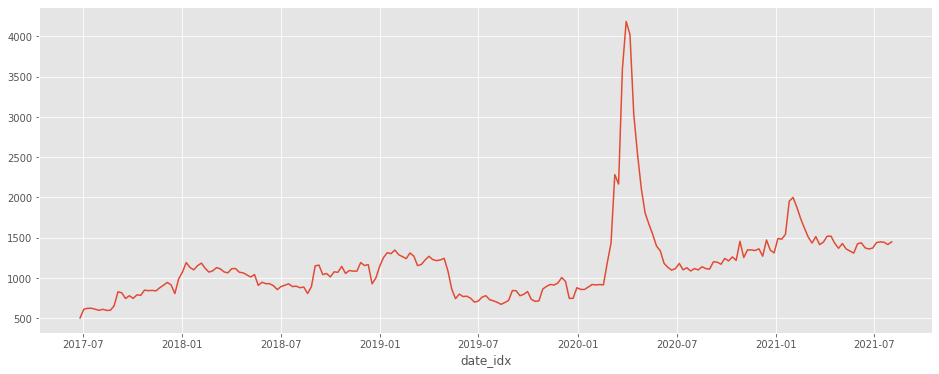

In [290]:
df.loc[df.zone_id == 18].total_demand_new.plot(figsize=(16,6))

In [377]:
df.loc[df.zone_id == 18].total_demand_new.tail(30)

date_idx
2021-01-11    1481.746103
2021-01-18    1543.741243
2021-01-25    1954.666690
2021-02-01    2000.858812
2021-02-08    1879.601251
2021-02-15    1737.901370
2021-02-22    1620.072589
2021-03-01    1508.151295
2021-03-08    1434.620766
2021-03-15    1514.658421
2021-03-22    1414.356378
2021-03-29    1446.099833
2021-04-05    1519.296260
2021-04-12    1519.499292
2021-04-19    1430.426261
2021-04-26    1368.991605
2021-05-03    1427.721385
2021-05-10    1360.898222
2021-05-17    1335.536666
2021-05-24    1309.468984
2021-05-31    1425.628997
2021-06-07    1437.209086
2021-06-14    1373.912866
2021-06-21    1360.600143
2021-06-28    1372.351886
2021-07-05    1439.705318
2021-07-12    1449.121010
2021-07-19    1443.767390
2021-07-26    1415.564233
2021-08-02    1449.469515
Name: total_demand_new, dtype: float64

In [ ]:
# see why 979 got so much worse with dampening
    # w/ dampening, it was much more variable - ie smoothing_trend changed drastically
    # maybe with seasonality it wouldn't be the case
    
# are the zones w/o seasonality much less accurate here?

In [289]:
pred, szn_estimate

(813.7110637715094, 1.0426791935654762)

In [234]:
pred, szn_estimate

(2650.7680153187093, 1.0)

In [251]:
pred, szn_estimate

(2924.7176680576495, 1.0)

In [271]:
pred, szn_estimate

(2712.5322486746827, 1.0)

In [98]:
res1.shape

(40, 6)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pred', ylabel='Density'>

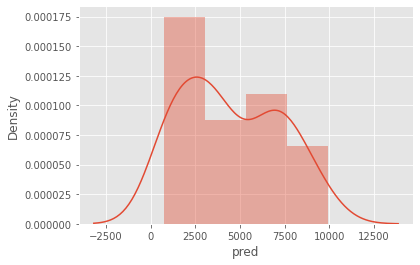

In [21]:
sns.distplot(res1.pred)

In [96]:
# res1.to_csv('./demand_fcast_fdate_08_02_21_new.csv', index=None)

# res1.to_csv('./demand_fcast_fdate_08_02_21.csv', index=None)
# res1.to_csv('./demand_fcast_fdate_07_26_21.csv', index=None)
# res1.to_csv('./demand_fcast_fdate_06_28_21.csv', index=None)

# res1.to_csv('./demand_fcast_fdate_07_19_21.csv', index=None)

In [378]:
map_estimate

{'initial_level_interval__': array(3.61517246),
 'smoothing_level_interval__': array(-2.12316123),
 'initial_trend_interval__': array(0.25236776),
 'smoothing_trend_interval__': array(12.99923226),
 'initial_szns': array([0.83038352, 0.76012183, 0.75279453, 0.88628208, 0.90501231,
        0.86038302, 0.93731951, 0.93292811, 0.93581486, 0.88642794,
        0.94338762, 0.93626328, 0.95235582, 0.9450432 , 0.98370182,
        0.99888438, 1.02945141, 0.98808666, 0.77323718, 0.87593455,
        0.88847362, 0.97808646, 0.94798021, 1.00577813, 1.1075718 ,
        1.18379714, 1.15332053, 1.13069795, 1.15565814, 1.17011937,
        1.1422845 , 1.10479522, 1.10783059, 1.15629594, 1.17136861,
        1.16501773, 1.19003942, 1.19340329, 1.15894588, 1.16380771,
        1.02059023, 1.00009442, 0.94133663, 0.91732083, 0.87157393,
        0.85111056, 0.85574755, 0.86182584, 0.86971744, 0.84721262,
        0.85957233, 0.8407361 ]),
 'smoothing_season_interval__': array(21.35840276),
 'covid_level_change

In [252]:
map_estimate

{'initial_level_interval__': array(1.98102599),
 'smoothing_level_interval__': array(1.28584013),
 'initial_trend_interval__': array(0.41221175),
 'smoothing_trend_interval__': array(-4.76748603),
 'covid_level_change_interval__': array(0.),
 'covid_level_change2_interval__': array(0.),
 'sigma_log__': array(4.89013795),
 'initial_level': array(845.16195077),
 'smoothing_level': array(0.78344226),
 'initial_trend': array(97.72949253),
 'smoothing_trend': array(0.00843006),
 'covid_level_change': array(2500.),
 'covid_level_change2': array(2500.),
 'sigma': array(132.971916)}

In [476]:
map_estimate

{'initial_level_interval__': array(11.96435453),
 'smoothing_level_interval__': array(1.82668726),
 'initial_trend_interval__': array(-1.38261687),
 'smoothing_trend_interval__': array(2.11727376),
 'covid_level_change_interval__': array(0.),
 'covid_level_change2_interval__': array(0.),
 'trend_dampener_interval__': array(-0.84218729),
 'sigma_log__': array(5.27661702),
 'initial_level': array(1291.99098299),
 'smoothing_level': array(0.86136661),
 'initial_trend': array(-386.83871398),
 'smoothing_trend': array(0.89257079),
 'covid_level_change': array(2500.),
 'covid_level_change2': array(2500.),
 'trend_dampener': array(0.30107432),
 'sigma': array(195.70668289)}

In [ ]:
# seems like covid_level_change2 is being used to allow the model to suddenly switch to a -ve trend in post-covid times
# maybe that's not bad though?

# forcing min of .15 for smoothing_trend looks better...
# but still need dampening for this case

# [X] try dampening w/o the .15 min for smoothing_trend
# [] try dampening w/ the .15 min for smoothing_trend

# parameter estimtes w/ the dampener look great

In [66]:
zdf.iloc[1:].reset_index().y_obs

0       624.273423
1       612.904018
2       598.826837
3       611.507891
4       597.768642
          ...     
137    1508.151295
138    1434.620766
139    1514.658421
140    1414.356378
141    1446.099833
Name: y_obs, Length: 142, dtype: float64

In [386]:
n_steps_ahead

5

In [ ]:
# Observtions
    # w/ szn: it seems to overfit in order to accomodate jaggedness in recent times
        # again wonder if weather made demand weird at that time
        # also smoothing things in general will help w/ this
        # and the fe handling
        # and prior that smooths szn estimates
        # prolly also using medians better
    # w/o szn: seems to clearly underfit..
    
    # in both cases, seems smoothing_level is too small. Wonder if should set min for it to .7 or so

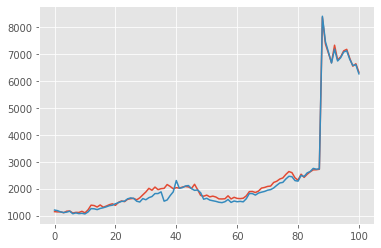

In [484]:
# 973 - fit on n_steps_ahead = 5 w/ szn + w/ dampener
zdf.iloc[n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

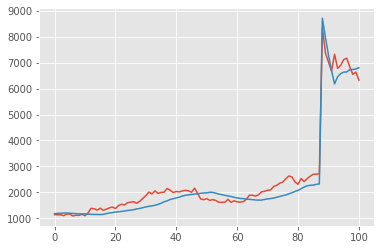

In [479]:
# 973 - fit on n_steps_ahead = 5 w/o szn + w/ dampener
zdf.iloc[n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

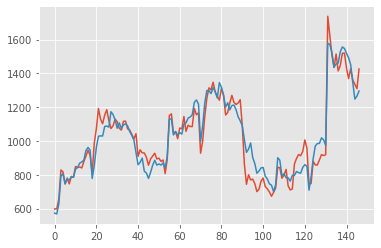

In [445]:
# 18 - fit on n_steps_ahead = 5 w/ szn + w/ dampener
zdf.iloc[n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

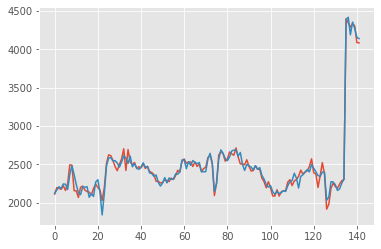

In [145]:
# 1
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

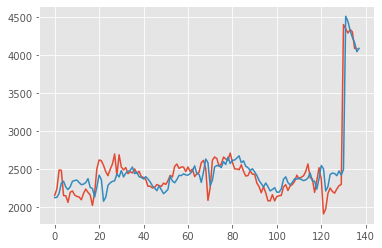

In [169]:
# 1 - fit on n_steps_ahead = 5
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

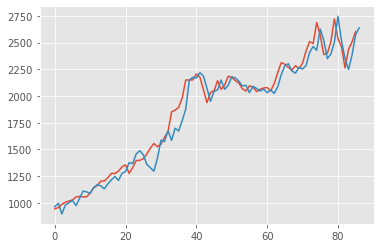

In [221]:
# 943 - fit on n_steps_ahead = 5 w/ szn + w/ dampener
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

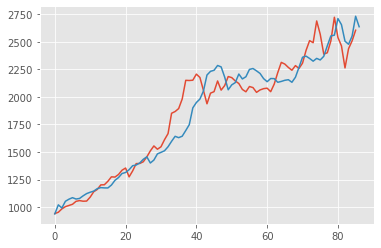

In [236]:
# 943 - fit on n_steps_ahead = 5 w/o szn + w/ dampener
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

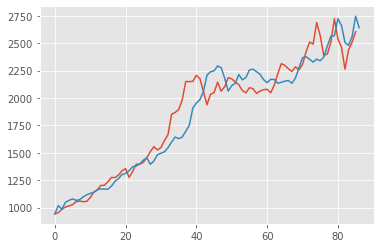

In [253]:
# 943 - fit on n_steps_ahead = 5 w/o szn + w/o dampener
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

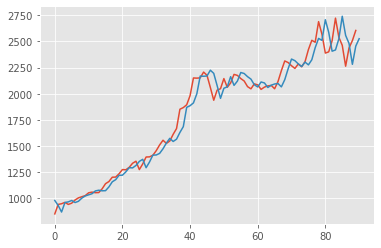

In [264]:
# 943 - fit on n_steps_ahead = 1 w/o szn + w/o dampener
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

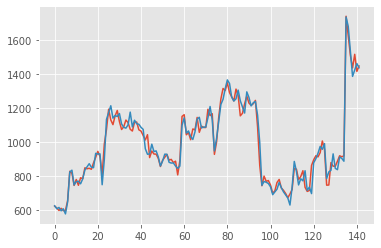

In [89]:
# 18
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

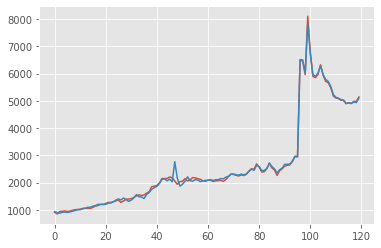

In [70]:
# Denver
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

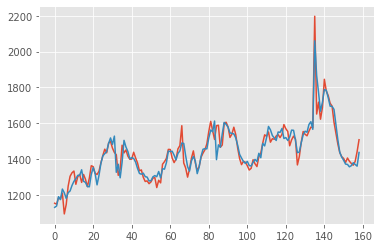

In [39]:
# Austin
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

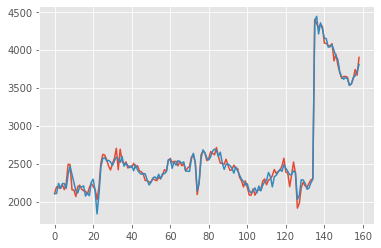

In [15]:
# SF
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

In [223]:
zdf.head()

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,...,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor,y_obs,covid_start_m1,covid_start_m5,y_obs_lag-1
0,943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914.304969
2018-04-16,943,2018-04-16,914.304969,878.349836,267.216062,71.564072,851.433443,942.071300,948.645956,734.767660,...,1217.129969,4,16,16,71.564072,17.007556,914.304969,0.0,0.0,851.433443
2018-04-23,943,2018-04-23,851.433443,914.304969,878.349836,267.216062,942.071300,948.645956,961.733155,920.843015,...,2131.434938,4,17,23,338.780134,6.291499,851.433443,0.0,0.0,942.071300
2018-04-30,943,2018-04-30,942.071300,851.433443,914.304969,878.349836,948.645956,961.733155,942.063498,919.029381,...,2911.304310,4,18,30,1217.129969,2.391942,942.071300,0.0,0.0,948.645956
2018-05-07,943,2018-05-07,948.645956,942.071300,851.433443,914.304969,961.733155,942.063498,954.090444,924.325349,...,3586.159548,5,19,7,2131.434938,1.682510,948.645956,0.0,0.0,961.733155


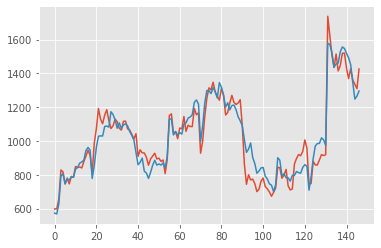

In [444]:
# 18 - fit on n_steps_ahead = 5 w/ szn + w/ dampener
# zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
zdf.iloc[n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

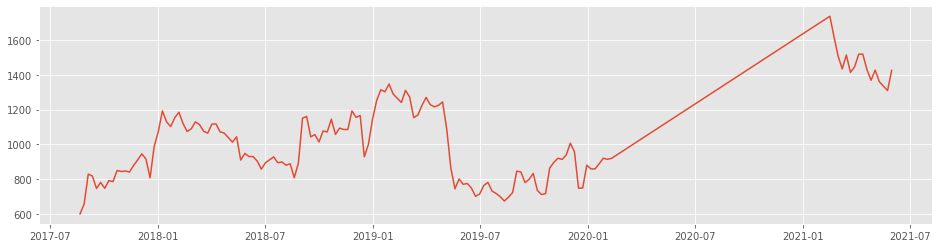

In [391]:
ax = zdf.iloc[1+n_steps_ahead:].y_obs.plot(figsize=(16,4))

In [485]:
# this aligns the szn estimates with the dates they are used to predict
all_season_estimates = map_estimate['initial_szns'].tolist() + seasons.get_test_value().tolist()

corresponding_dates = zdf.iloc[1:].date.tolist()
for i in range(szn_len):
    corresponding_dates += [corresponding_dates[-1] + timedelta(weeks=1)]

szn_estimates_w_dates = pd.DataFrame(list(zip(all_season_estimates, corresponding_dates)), columns=['szn_estimate', 'date'])

szn_estimates_w_dates = szn_estimates_w_dates.set_index(szn_estimates_w_dates.date)

In [406]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.date >= f_date].head()

,szn_estimate,date
date,,
2021-06-07,0.819382,2021-06-07
2021-06-14,0.798019,2021-06-14
2021-06-21,0.761505,2021-06-21
2021-06-28,0.787919,2021-06-28
2021-07-05,0.825717,2021-07-05


In [226]:
szn_estimates_w_dates['szn_estimate_lag1'] = szn_estimates_w_dates.szn_estimate.shift(1)
szn_estimates_w_dates['szn_change'] = szn_estimates_w_dates.szn_estimate - szn_estimates_w_dates.szn_estimate_lag1
szn_estimates_w_dates['szn_change_abs'] = szn_estimates_w_dates['szn_change'].abs()

In [227]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.szn_change_abs > .1]

,szn_estimate,date,szn_estimate_lag1,szn_change,szn_change_abs
date,,,,,
2019-01-28,1.068694,2019-01-28,0.959993,0.108701,0.108701
2019-02-04,1.207202,2019-02-04,1.068694,0.138508,0.138508
2020-01-27,1.068693,2020-01-27,0.959992,0.108701,0.108701
2020-02-03,1.207202,2020-02-03,1.068693,0.138509,0.138509


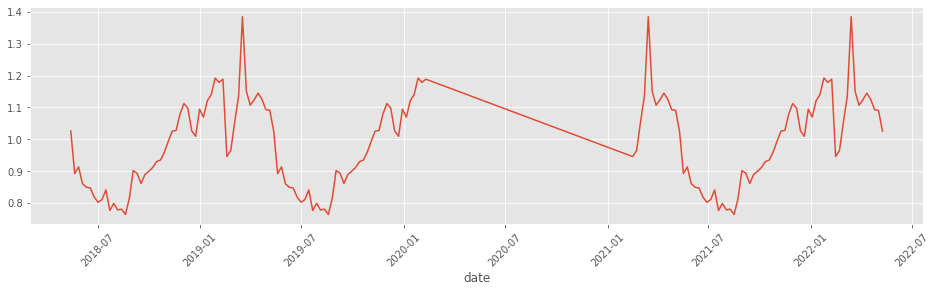

In [486]:
ax = szn_estimates_w_dates.szn_estimate.plot(figsize=(16,4))
ax.xaxis.set_tick_params(rotation=45)

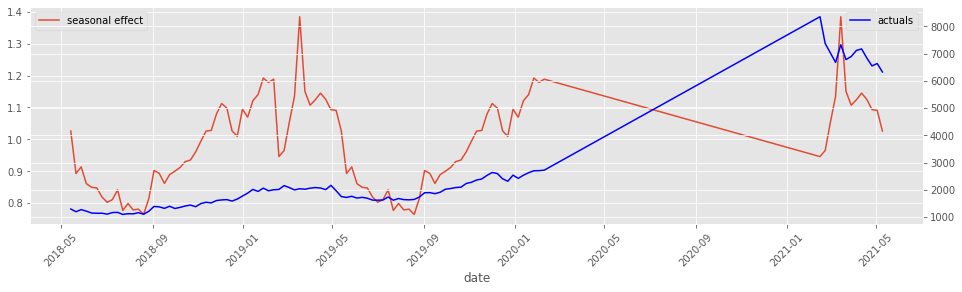

In [487]:
ax = szn_estimates_w_dates.iloc[:-szn_len].szn_estimate.plot(figsize=(16,4), label='seasonal effect')
ax2 = ax.twinx()
zdf.iloc[1:].y_obs.plot(ax=ax2, color='blue', label='actuals')
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
ax2.legend()

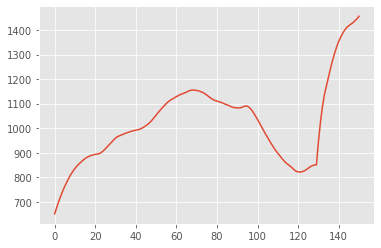

In [410]:
plt.plot(levels.get_test_value())

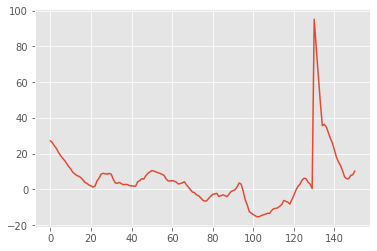

In [421]:
plt.plot(trends.get_test_value())

In [418]:
pred

1261.3966827206596

In [419]:
levels.get_test_value()[-1]

1455.649196677878

In [423]:
map_estimate['trend_dampener']

array(0.89205609)

In [441]:
np.sum([map_estimate['trend_dampener']**i for i in range(1,4+1)])

3.0309268068583104

In [425]:
HORIZON

5

In [426]:
trend_multiplier = np.sum([map_estimate['trend_dampener']**i for i in range(1,HORIZON+1)])
trend_multiplier*trends.get_test_value()[-1]

36.66397173536055

In [427]:
trend_multiplier

3.595812813899471

In [178]:
res_2.shape

(42, 6)

In [185]:
res_2

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season
0,2021-07-12,1,3529.928828,0.05894797521212613,0.13428735809544573,0.00010948949174302699
1,2021-07-12,13,714.436457,0.10628517202714051,0.00010491188227270891,6.92558450578588e-20
2,2021-07-12,785,8220.921848,0.0412676866422877,1.0,0.7999999662546676
3,2021-07-12,943,4177.709767,3.646157493097808e-06,0.9999999999975033,5.1602151633132955e-05
4,2021-07-12,861,5771.605176,4.962854729734045e-07,0.9999607833851644,7.107493839318599e-07
5,2021-07-12,18,1069.353319,0.15162544843622017,0.011691807427723364,2.193624152010232e-08
6,2021-06-21,1,3550.012063,0.058784156904635315,0.08690959550283689,2.1351266061360414e-07
7,2021-06-21,13,728.473789,0.10798615167706684,0.00040432705736087864,1.8471271643907779e-19
8,2021-06-21,785,9016.456087,3.224411277224251e-06,1.0,3.7408376157264076e-10
9,2021-06-21,943,4883.481913,0.013475620752850042,0.9999952338038494,3.774336634355181e-07


In [183]:
res_2['pred_for_date'] = res_2.pred_for_date.apply(lambda x: x.date())

f1 = res_2.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f1 = f1.set_index(f1.pred_for_date)

f1['error_new'] = f1.pred - f1.total_demand_new
f1['pct_error_new'] = f1.error_new / f1.total_demand_new
f1['abs_error_new'] = f1.error_new.abs()
f1['abs_pct_error_new'] = f1.pct_error_new.abs()

f1['error_old'] = f1[f'total_demand_new_lag{HORIZON+1}'] - f1.total_demand_new
f1['pct_error_old'] = f1.error_old / f1.total_demand_new
f1['abs_error_old'] = f1.error_old.abs()
f1['abs_pct_error_old'] = f1.pct_error_old.abs()

f1.shape

(42, 34)

In [215]:
f1.shape

(42, 34)

In [217]:
f1.loc[f1.date >= date(2021,1,1)][['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,24.000000,24.000000,24.000000,24.000000
mean,0.093292,0.083822,-0.034337,0.077309
std,0.080137,0.068660,0.119472,0.076218
min,0.001062,0.000219,-0.274823,-0.024750
25%,0.034803,0.024177,-0.096593,0.016291
50%,0.067371,0.071827,-0.022818,0.071827
75%,0.148342,0.119732,0.034373,0.119732
max,0.274823,0.222857,0.204235,0.222857


In [184]:
f1[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,42.000000,42.000000,42.000000,42.000000
mean,0.122441,0.083175,0.040840,0.022238
std,0.091586,0.066755,0.148449,0.105054
min,0.001062,0.000219,-0.274823,-0.230231
25%,0.056642,0.026355,-0.058634,-0.023042
50%,0.099000,0.069486,0.036353,0.032253
75%,0.176214,0.118924,0.130616,0.075658
max,0.331227,0.230231,0.331227,0.222857


In [100]:
res_18['pred_for_date'] = res_18.pred_for_date.apply(lambda x: x.date())

f_18 = res_18.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_18 = f_18.set_index(f_18.pred_for_date)

f_18['error_new'] = f_18.pred - f_18.total_demand_new
f_18['pct_error_new'] = f_18.error_new / f_18.total_demand_new
f_18['abs_error_new'] = f_18.error_new.abs()
f_18['abs_pct_error_new'] = f_18.pct_error_new.abs()

f_18['error_old'] = f_18.total_demand_new_lag6 - f_18.total_demand_new
f_18['pct_error_old'] = f_18.error_old / f_18.total_demand_new
f_18['abs_error_old'] = f_18.error_old.abs()
f_18['abs_pct_error_old'] = f_18.pct_error_old.abs()

f_18.shape

(40, 34)

In [125]:
res_2['pred_for_date'] = res_2.pred_for_date.apply(lambda x: x.date())

f_2 = res_2.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_2 = f_2.set_index(f_2.pred_for_date)

f_2['error_new'] = f_2.pred - f_2.total_demand_new
f_2['pct_error_new'] = f_2.error_new / f_2.total_demand_new
f_2['abs_error_new'] = f_2.error_new.abs()
f_2['abs_pct_error_new'] = f_2.pct_error_new.abs()

f_2['error_old'] = f_2.total_demand_new_lag6 - f_2.total_demand_new
f_2['pct_error_old'] = f_2.error_old / f_2.total_demand_new
f_2['abs_error_old'] = f_2.error_old.abs()
f_2['abs_pct_error_old'] = f_2.pct_error_old.abs()

f_2.shape

(40, 34)

In [120]:
res_979['pred_for_date'] = res_979.pred_for_date.apply(lambda x: x.date())

f_979 = res_979.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_979 = f_979.set_index(f_979.pred_for_date)

f_979['error_new'] = f_979.pred - f_979.total_demand_new
f_979['pct_error_new'] = f_979.error_new / f_979.total_demand_new
f_979['abs_error_new'] = f_979.error_new.abs()
f_979['abs_pct_error_new'] = f_979.pct_error_new.abs()

f_979['error_old'] = f_979.total_demand_new_lag6 - f_979.total_demand_new
f_979['pct_error_old'] = f_979.error_old / f_979.total_demand_new
f_979['abs_error_old'] = f_979.error_old.abs()
f_979['abs_pct_error_old'] = f_979.pct_error_old.abs()

f_979.shape

(4, 34)

In [101]:
f_18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,40.000000,40.000000,40.000000,40.000000
mean,0.075001,0.077489,0.016754,0.055337
std,0.047354,0.047358,0.087885,0.072530
min,0.002159,0.000219,-0.167116,-0.067237
25%,0.035874,0.048648,-0.052630,0.000858
50%,0.070538,0.071827,-0.001226,0.071827
75%,0.106740,0.094899,0.097629,0.094899
max,0.167116,0.222857,0.161214,0.222857


In [126]:
f_2[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,40.000000,40.000000,40.000000,40.000000
mean,0.065501,0.077489,-0.015166,0.055337
std,0.041684,0.047358,0.076825,0.072530
min,0.003648,0.000219,-0.167032,-0.067237
25%,0.030128,0.048648,-0.075626,0.000858
50%,0.066086,0.071827,-0.024305,0.071827
75%,0.089186,0.094899,0.053608,0.094899
max,0.167032,0.222857,0.128020,0.222857


In [146]:
res_2

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season
0,2021-05-10,1,4033.230571,0.6730970258344603,0.9562542499464046,7.486677608097867e-05


In [157]:
res_2

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season
0,2021-05-10,1,3861.550089,0.4901616533203609,0.9999999999999998,9.100920490994391e-07


In [147]:
f_2.loc[f_2.zone_id == 1]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,1,3663.686118,0.3704189850370301,0.9378583763738273,2.2575799925353617e-06,2021-07-26,3898.141821,3663.909110,3738.906556,...,3636.043192,3647.575226,-234.455703,-0.060146,234.455703,0.060146,-262.098629,-0.067237,262.098629,0.067237
2021-06-21,2021-06-21,1,3514.968919,0.3583951992706179,0.9967392659596457,6.353781180747261e-06,2021-06-21,3531.253737,3636.043192,3647.575226,...,3799.919630,3940.326206,-16.284818,-0.004612,16.284818,0.004612,268.665893,0.076082,268.665893,0.076082
2021-05-31,2021-05-31,1,3837.424072,0.3686169629421041,0.99957725310136,2.767565606973364e-05,2021-05-31,3646.368284,3621.476264,3695.795111,...,4078.520633,4049.343485,191.055788,0.052396,191.055788,0.052396,432.152349,0.118516,432.152349,0.118516
2021-05-10,2021-05-10,1,4049.796299,0.519909828109595,0.48112120574418893,2.0587380291332855e-32,2021-05-10,3799.919630,3940.326206,3852.311690,...,4082.580131,4086.456143,249.876669,0.065758,249.876669,0.065758,282.660501,0.074386,282.660501,0.074386


/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


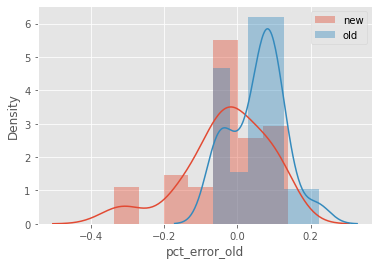

In [39]:
ax = sns.distplot(f1.pct_error_new, label='new')
sns.distplot(f1.pct_error_old, label='old', ax=ax)
ax.legend()

In [186]:
### zone performance

zp = f1.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp.columns = ['_'.join(col).strip() for col in zp.columns.values]

zp['mean_diff'] = zp.abs_pct_error_new_mean - zp.abs_pct_error_old_mean
zp['median_diff'] = zp.abs_pct_error_new_median - zp.abs_pct_error_old_median

zp.reset_index(inplace=True)

zp.head(2)

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.054518,0.055893,0.072278,0.074386,-0.017760,-0.018493
1,13,0.093222,0.092116,0.124866,0.076099,-0.031644,0.016017


In [102]:
### zone performance

zp_18 = f_18.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp_18.columns = ['_'.join(col).strip() for col in zp_18.columns.values]

zp_18['mean_diff'] = zp_18.abs_pct_error_new_mean - zp_18.abs_pct_error_old_mean
zp_18['median_diff'] = zp_18.abs_pct_error_new_median - zp_18.abs_pct_error_old_median

zp_18.reset_index(inplace=True)

zp_18.head(2)

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.045728,0.056271,0.084055,0.075234,-0.038327,-0.018963
1,13,0.047062,0.040339,0.133793,0.141948,-0.086730,-0.101609


In [187]:
zp.sort_values('median_diff')

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
4,861,0.109522,0.065328,0.096831,0.111411,0.012691,-0.046082
0,1,0.054518,0.055893,0.072278,0.074386,-0.017760,-0.018493
1,13,0.093222,0.092116,0.124866,0.076099,-0.031644,0.016017
3,785,0.111019,0.086781,0.042528,0.031168,0.068491,0.055613
5,943,0.155766,0.204235,0.101868,0.106596,0.053899,0.097639
2,18,0.210601,0.262068,0.060678,0.062013,0.149923,0.200055


In [103]:
zp_18.sort_values('median_diff')

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
1,13,0.047062,0.040339,0.133793,0.141948,-0.086730,-0.101609
9,1001,0.068567,0.057377,0.086399,0.082613,-0.017832,-0.025236
0,1,0.045728,0.056271,0.084055,0.075234,-0.038327,-0.018963
4,785,0.058228,0.058497,0.064806,0.060270,-0.006578,-0.001773
6,972,0.085056,0.083107,0.071243,0.071914,0.013813,0.011193
5,942,0.079223,0.086279,0.079233,0.074767,-0.000010,0.011512
7,973,0.081674,0.093718,0.073722,0.081308,0.007952,0.012410
3,27,0.061881,0.070641,0.048958,0.056653,0.012923,0.013988
8,979,0.124872,0.151695,0.108775,0.117758,0.016097,0.033936
2,18,0.097718,0.093123,0.023904,0.016394,0.073814,0.076729


In [104]:
f1.loc[f1.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2344.584750,0.7183027611910529,0.0213751966495799,0.0,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-470.512698,-0.167139,470.512698,0.167139,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2500.964704,0.668796170540601,0.023731203089671398,0.0,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-74.198070,-0.028813,74.198070,0.028813,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,2864.895043,0.8070502550666803,0.01829791801622242,0.0,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,118.055695,0.042979,118.055695,0.042979,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,2901.628811,0.784017743670635,0.02159284488940072,0.0,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,84.003005,0.029813,84.003005,0.029813,398.306254,0.141362,398.306254,0.141362


In [105]:
f_18.loc[f_18.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2344.650761,0.7182712859320518,0.021369210749744322,0.0,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-470.446687,-0.167116,470.446687,0.167116,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2500.523865,0.6735785920262594,0.023698043493554474,0.0,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-74.638910,-0.028984,74.638910,0.028984,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,3137.372026,0.4869326992861085,0.999999344974056,0.0,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,390.532678,0.142175,390.532678,0.142175,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,3271.867882,0.47623189225162105,0.9999808519732066,0.0,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,454.242076,0.161214,454.242076,0.161214,398.306254,0.141362,398.306254,0.141362


In [121]:
f_979.loc[f_979.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2694.352380,0.4280264571088128,0.8356378362755952,1.379109197721045e-05,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-120.745068,-0.042892,120.745068,0.042892,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2541.864616,0.4286242228133984,0.9247243010826816,2.438283183931437e-05,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-33.298159,-0.012931,33.298159,0.012931,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,2904.077197,0.7416090407942576,0.23161838632312984,8.377424588706081e-05,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,157.237849,0.057243,157.237849,0.057243,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,3154.889655,0.7684749021387602,0.20016980332303683,5.5488076952358854e-05,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,337.263849,0.119698,337.263849,0.119698,398.306254,0.141362,398.306254,0.141362


In [114]:
f_18.loc[f_18.smoothing_season == 0.0][['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,20.000000,20.000000,20.000000,20.000000
mean,0.091855,0.086404,0.052988,0.065170
std,0.048083,0.030613,0.090763,0.065766
min,0.002159,0.042229,-0.167116,-0.059860
25%,0.053563,0.058913,-0.025090,0.046966
50%,0.100962,0.089845,0.093718,0.089845
75%,0.132766,0.101066,0.121350,0.101066
max,0.167116,0.143511,0.161214,0.143511


In [115]:
f_18.loc[f_18.smoothing_season != 0.0][['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,20.000000,20.000000,20.000000,20.000000
mean,0.058147,0.068574,-0.019480,0.045505
std,0.041143,0.059154,0.069658,0.079179
min,0.004612,0.000219,-0.167032,-0.067237
25%,0.027875,0.030732,-0.068527,-0.006940
50%,0.062952,0.064922,-0.027404,0.052281
75%,0.079486,0.074810,0.016730,0.074810
max,0.167032,0.222857,0.102730,0.222857


In [109]:
f_18[['zone_id', 'date', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'total_demand_new', 'pred', 'total_demand_new_lag6', 'pct_error_new', 'pct_error_old', 'error_new', 'error_old']].sort_values(['zone_id', 'pred_for_date'])

,zone_id,date,smoothing_level,smoothing_trend,smoothing_season,total_demand_new,pred,total_demand_new_lag6,pct_error_new,pct_error_old,error_new,error_old
pred_for_date,,,,,,,,,,,,
2021-05-10,1,2021-05-10,0.519909828109595,0.48112120574418893,2.0587380291332855e-32,3799.919630,4049.796299,4082.580131,0.065758,0.074386,249.876669,282.660501
2021-05-31,1,2021-05-31,0.3686169629421041,0.99957725310136,2.767565606973364e-05,3646.368284,3837.424072,4078.520633,0.052396,0.118516,191.055788,432.152349
2021-06-21,1,2021-06-21,0.3583951992706179,0.9967392659596457,6.353781180747261e-06,3531.253737,3514.968919,3799.919630,-0.004612,0.076082,-16.284818,268.665893
2021-07-26,1,2021-07-26,0.3704189850370301,0.9378583763738273,2.2575799925353617e-06,3898.141821,3663.686118,3636.043192,-0.060146,-0.067237,-234.455703,-262.098629
2021-05-10,13,2021-05-10,0.7696821290210248,0.19804270518386838,9.069323276782556e-05,848.401123,911.745389,1028.345999,0.074663,0.212099,63.344266,179.944876
2021-05-31,13,2021-05-31,0.749692586490308,0.2163929474579398,2.2256166426181486e-05,825.454785,910.253574,1009.413478,0.102730,0.222857,84.798788,183.958692
2021-06-21,13,2021-06-21,0.787173878272498,0.18242723911304506,1.6988797915875554e-06,791.569353,795.401840,848.401123,0.004842,0.071796,3.832487,56.831771
2021-07-26,13,2021-07-26,0.7565958619756966,0.20571542355929504,5.566798452302579e-05,822.498868,817.551517,799.124850,-0.006015,-0.028418,-4.947351,-23.374018
2021-05-10,18,2021-05-10,0.740489583130101,0.3137934964537862,0.00019216976329419988,1360.898222,1246.225216,1446.099833,-0.084263,0.062607,-114.673006,85.201611


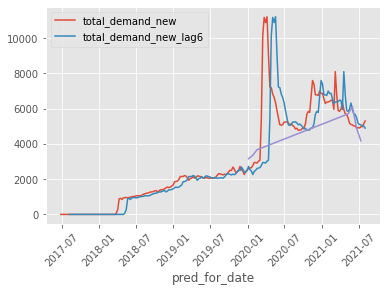

In [188]:
ax = df.loc[(df.zone_id == 943)
#             &(df.date <= f_date + timedelta(weeks=HORIZON))
           ][['total_demand_new', 'total_demand_new_lag6']].plot()

f1.loc[f1.zone_id == 943].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

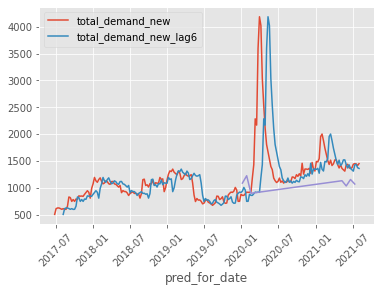

In [189]:
ax = df.loc[(df.zone_id == 18)
#             &(df.date <= f_date + timedelta(weeks=HORIZON))
           ][['total_demand_new', 'total_demand_new_lag6']].plot()

f1.loc[f1.zone_id == 18].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

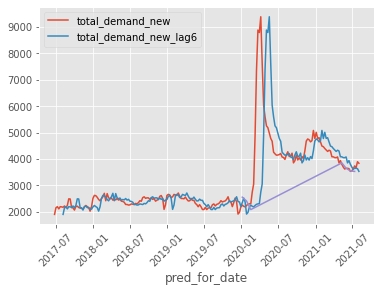

In [190]:
ax = df.loc[(df.zone_id == 1)
#             &(df.date <= f_date + timedelta(weeks=HORIZON))
           ][['total_demand_new', 'total_demand_new_lag6']].plot()

f1.loc[f1.zone_id == 1].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

<AxesSubplot:xlabel='date_idx'>

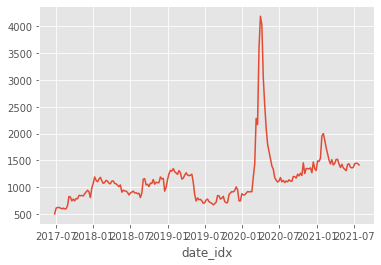

In [49]:
df.loc[df.zone_id == 18].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

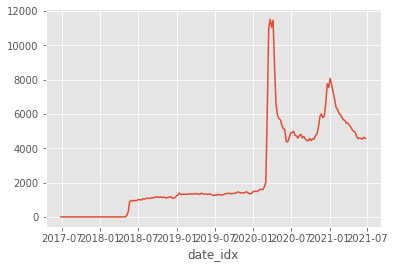

In [431]:
df.loc[df.zone_id == 983].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

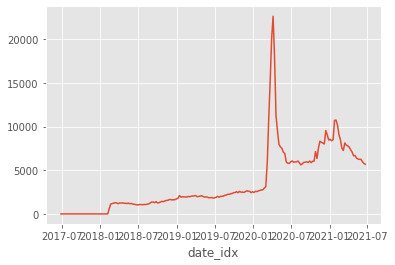

In [433]:
df.loc[df.zone_id == 861].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

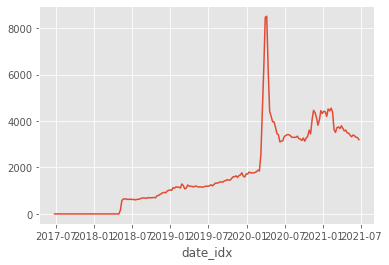

In [434]:
df.loc[df.zone_id == 989].total_demand_new.plot()

In [ ]:
# btm 3 (1001, 943, 787)

In [736]:
f4.loc[f4.zone_id == 974][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,4635.691899,4425.085032,4783.576204
2021-05-31,2021-05-31,4783.576204,4487.976940,4901.835912
2021-05-10,2021-05-10,4901.835912,5107.128759,5314.633336
2021-04-19,2021-04-19,5314.633336,5741.627466,5328.496810
2020-01-27,2020-01-27,2734.623225,2729.935405,2688.233743
2020-01-06,2020-01-06,2688.233743,2859.332854,2290.397509
2019-12-16,2019-12-16,2290.397509,2091.314580,2571.524910


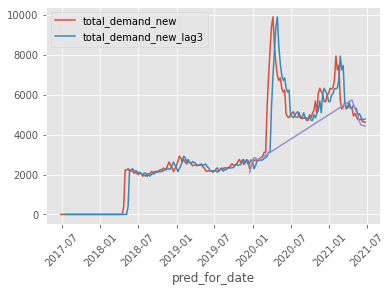

In [732]:
ax = df.loc[df.zone_id == 974][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 974].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [733]:
f4.loc[f4.zone_id == 972][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,6428.423384,5920.677019,6512.364852
2021-05-31,2021-05-31,6512.364852,6308.358613,6642.146212
2021-05-10,2021-05-10,6642.146212,6914.151477,7097.163660
2021-04-19,2021-04-19,7097.163660,7147.823689,7299.164351
2020-01-27,2020-01-27,3031.638005,2889.873568,2959.022573
2020-01-06,2020-01-06,2959.022573,3161.603770,2606.750241
2019-12-16,2019-12-16,2606.750241,2623.576807,2909.170012


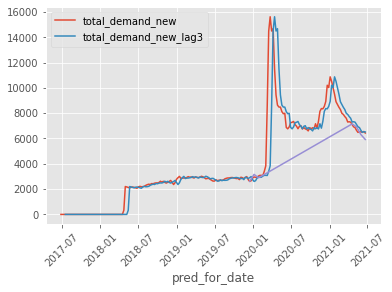

In [734]:
ax = df.loc[df.zone_id == 972][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 972].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [509]:
f1.loc[f1.zone_id == 787][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,3004.375691,8.526171e+02,3265.079548
2021-05-31,2021-05-31,3265.079548,-1.013012e+02,3259.695788
2021-05-10,2021-05-10,3259.695788,-3.164240e+03,3560.283871
2021-04-19,2021-04-19,3560.283871,1.960622e+06,3637.874023
2020-01-27,2020-01-27,1461.759721,1.494049e+03,1335.743291
2020-01-06,2020-01-06,1335.743291,1.524767e+03,1263.330682
2019-12-16,2019-12-16,1263.330682,1.314865e+03,1253.453050


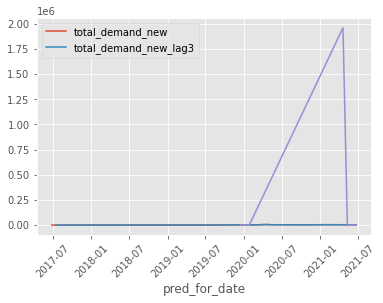

In [510]:
ax = df.loc[df.zone_id == 787][['total_demand_new', 'total_demand_new_lag3']].plot()

f1.loc[f1.zone_id == 787].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


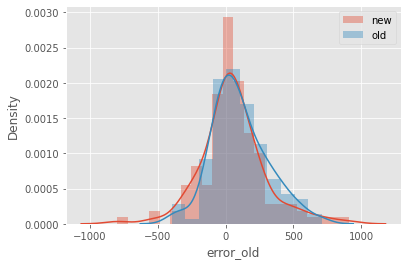

In [737]:
ax = sns.distplot(f4.error_new, label='new')
sns.distplot(f4.error_old, label='old')

ax.legend(loc='best')